In [1]:
# ! pip install pca
# from pca import pca

In [2]:
from sklearn.decomposition import PCA

In [3]:
import json
import os
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# TODO: Get PCA columns, delete DF, load again DF, concayt user_d to PCA columns, save to csv

In [4]:
file_path = f"{ os.getcwd() }/output/"
file_folder = "05.prepoc_knn/"
file_folder_postproc = "06.final/"
file_name = "05.preproc"
file_name_knn = "05.preproc_knn"
file_name_postproc = "06.pca"

In [5]:
random_seed = 66

In [6]:
df = pd.read_csv(file_path + file_folder + "/" + file_name + ".csv", low_memory=False)
df = df[df["user.id_str"] != "False"]
df = df.dropna()
del df["text"]
del df["retweeted_status.text"]
del df["quoted_status.text"]
del df["retweeted_status.quoted_status.text"]
del df["full_text"]
del df["hashtags"]
del df["retweeted_status.hashtags"]
del df["quoted_status.hashtags"]

users = df["user.id_str"]
# df = pd.read_parquet(file_path + file_folder + "/" + file_name_knn + ".parquet")

In [13]:
for i in [
    "user.followers_count",
    "user.friends_count",
    "user.listed_count",
    "user.favourites_count",
    "quote_count",
]:
    print(
        f"cantidad de datos no numéricos en columna '{i}': {df[pd.to_numeric(df[i], errors='coerce').isnull()].shape[0]}."
    )
    df[i] = pd.to_numeric(df[i], errors="coerce")
    df[df[i].isna()][i] = 0.0001
    df[df[i] == 0][i] = 0.0001
    df[i] = np.log10(df[i].astype(float))
    df[i] = df[i].replace([-np.inf], 0)
    df[i] = df[i].replace([np.inf], 0)
    df[i].fillna(0.0001)

cantidad de datos no numéricos en columna 'user.followers_count': 0.


<ipython-input-13-77f0b7ecaf5d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df[i] == 0][i] = 0.0001
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


cantidad de datos no numéricos en columna 'user.friends_count': 0.
cantidad de datos no numéricos en columna 'user.listed_count': 0.
cantidad de datos no numéricos en columna 'user.favourites_count': 0.
cantidad de datos no numéricos en columna 'quote_count': 0.


In [8]:
# df.shape

# (78859, 5019)

In [9]:
def transform_df(df):
    df["Android"] = (df["source"].str.strip() == "Twitter for Android").astype(int)
    df["iOS"] = (
        (df["source"].str.strip() == "Twitter for iPhone")
        | (df["source"].str.strip() == "Twitter for iPad")
        | (df["source"].str.strip() == "Twitter for Mac")
    ).astype(int)
    df["Web"] = (df["source"].str.strip() == "Twitter Web App").astype(int)
    df["Others"] = (
        (df["source"].str.strip() != "Twitter for Android")
        & (df["source"].str.strip() != "Twitter for iPhone")
        & (df["source"].str.strip() != "Twitter for iPad")
        & (df["source"].str.strip() != "Twitter for Mac")
        & (df["source"].str.strip() != "Twitter Web App")
    ).astype(int)

    df["user.verified"] = df["user.verified"].fillna(0).astype(int)

    del df["source"]
    del df["user.id_str"]

    return df

In [10]:
df = transform_df(df)

In [15]:
model_pca = PCA(4)
# model_pca = pca(n_components=3)

# Transform the data
pca_result = model_pca.fit_transform(df)

pca_result.shape

(78856, 4)

In [14]:
# for i in [
#     "user.followers_count",
#     "user.friends_count",
#     "user.listed_count",
#     "user.favourites_count",
#     "quote_count",
#     "lula",
# ]:
#     print(f"{i}: {np.any(np.isnan(df[i]))}")
#     print(f"{i}: {np.all(np.isfinite(df[i]))}")
#     print(f"{i}: {max(df[i])}")

user.followers_count: False
user.followers_count: True
user.followers_count: 0.8692564116022982
user.friends_count: False
user.friends_count: True
user.friends_count: 0.7802296858915663
user.listed_count: False
user.listed_count: True
user.listed_count: 0.70986368300573
user.favourites_count: False
user.favourites_count: True
user.favourites_count: 0.8031888709464644
quote_count: False
quote_count: True
quote_count: 0.0
lula: False
lula: True
lula: 124


In [16]:
# df["user.favourites_count"].value_counts()

 0.000000    966
-0.521390    222
-0.321371    177
-0.155541    141
-0.108936    136
            ... 
 0.675455      1
 0.681035      1
 0.620450      1
 0.726595      1
 0.732090      1
Name: user.favourites_count, Length: 42560, dtype: int64

In [17]:
model_pca.explained_variance_ratio_
# Plot explained variance
# fig, ax = model_pca.plot()

array([0.18161962, 0.06043327, 0.03670232, 0.03014696])

In [18]:
df_pca = pd.DataFrame(pca_result, columns=["PCA_1", "PCA_2", "PCA_3", "PCA_4"])
# df_pca = pd.DataFrame(pca_result, columns=["PCA_1", "PCA_2"])
# df_pca['label'] = labels
df_pca.head()

PCA_1     PCA_2     PCA_3     PCA_4
0  3.282642  0.768869 -0.022443 -0.993685
1 -1.530911  0.256849  0.002600  0.114886
2 -1.519970 -0.650976 -0.028492  0.348947
3 -1.824125  0.038848 -0.004451  0.200283
4 -2.177256  0.042008 -0.000469  0.033148

In [ ]:
!pip install bioinfokit
# from bioinfokit.visuz import cluster

In [19]:
# # Getting unique labels
# u_labels = np.unique(labels)

# # plotting the results:
# plt.figure(figsize=(20, 10))
# for i in u_labels:
#     plt.scatter(
#         df_pca[df_pca.label == i].PCA_1, df_pca[df_pca.label == i].PCA_1, label=i
#     )
# plt.legend()
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


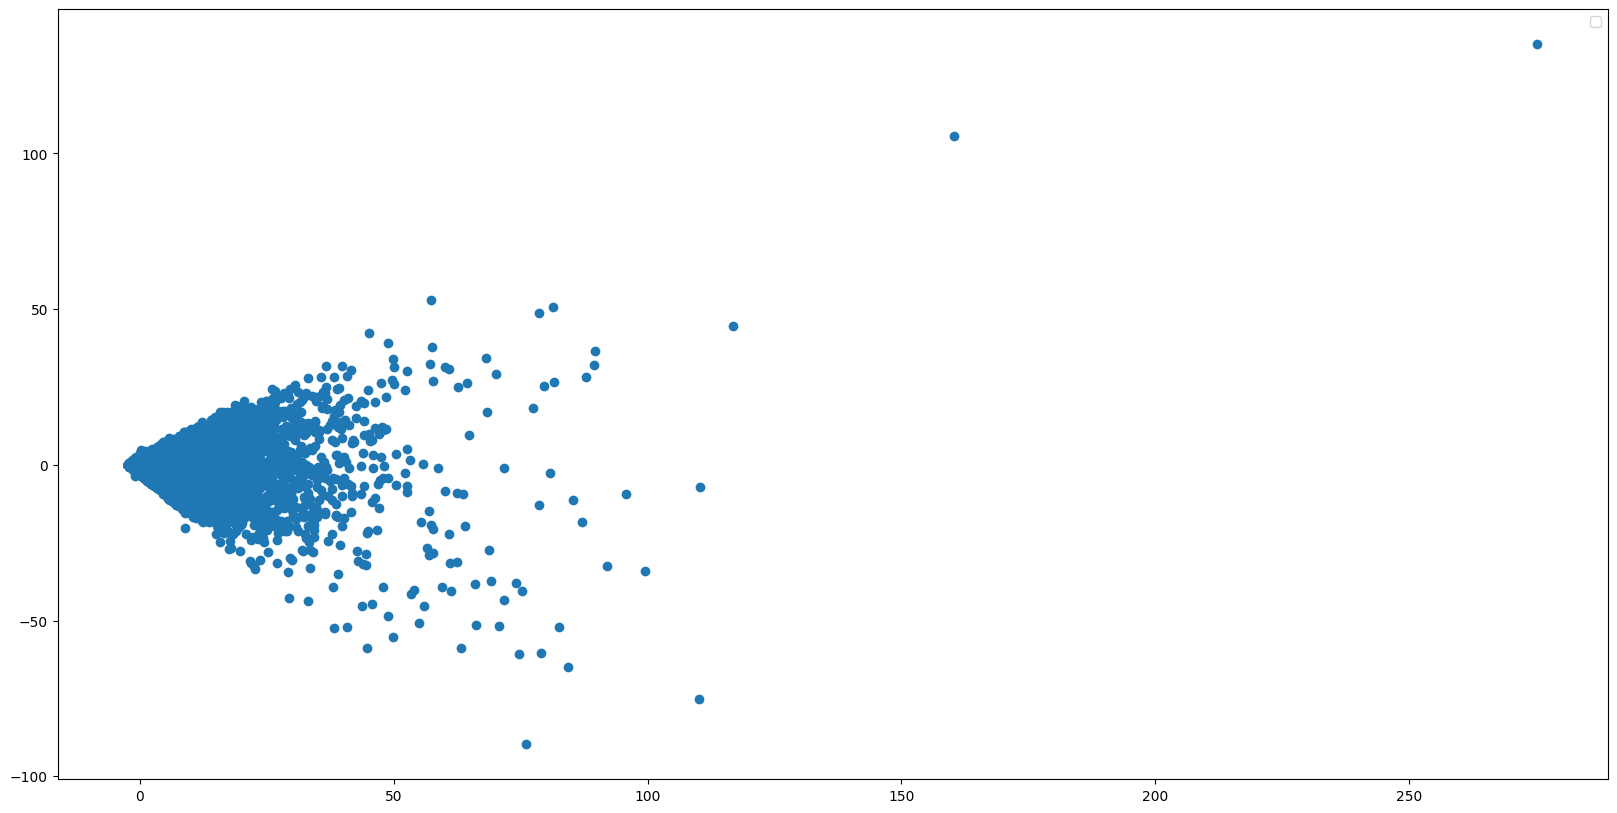

In [20]:
# plotting the results:
plt.figure(figsize=(20, 10))
plt.scatter(df_pca.PCA_1, df_pca.PCA_2)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


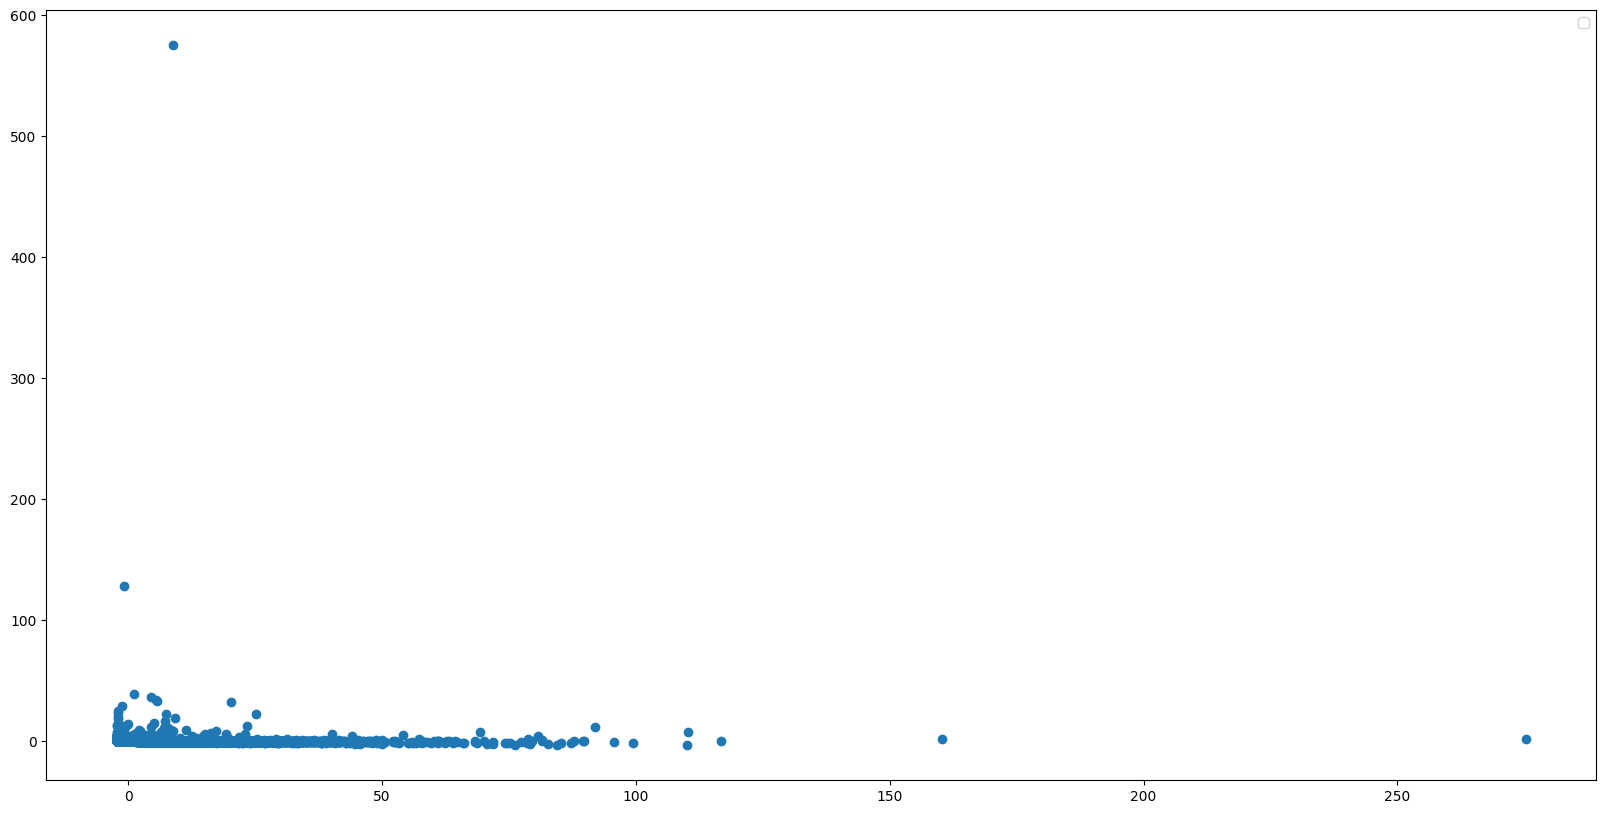

In [21]:
# plotting the results:
plt.figure(figsize=(20, 10))
plt.scatter(df_pca.PCA_1, df_pca.PCA_3)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


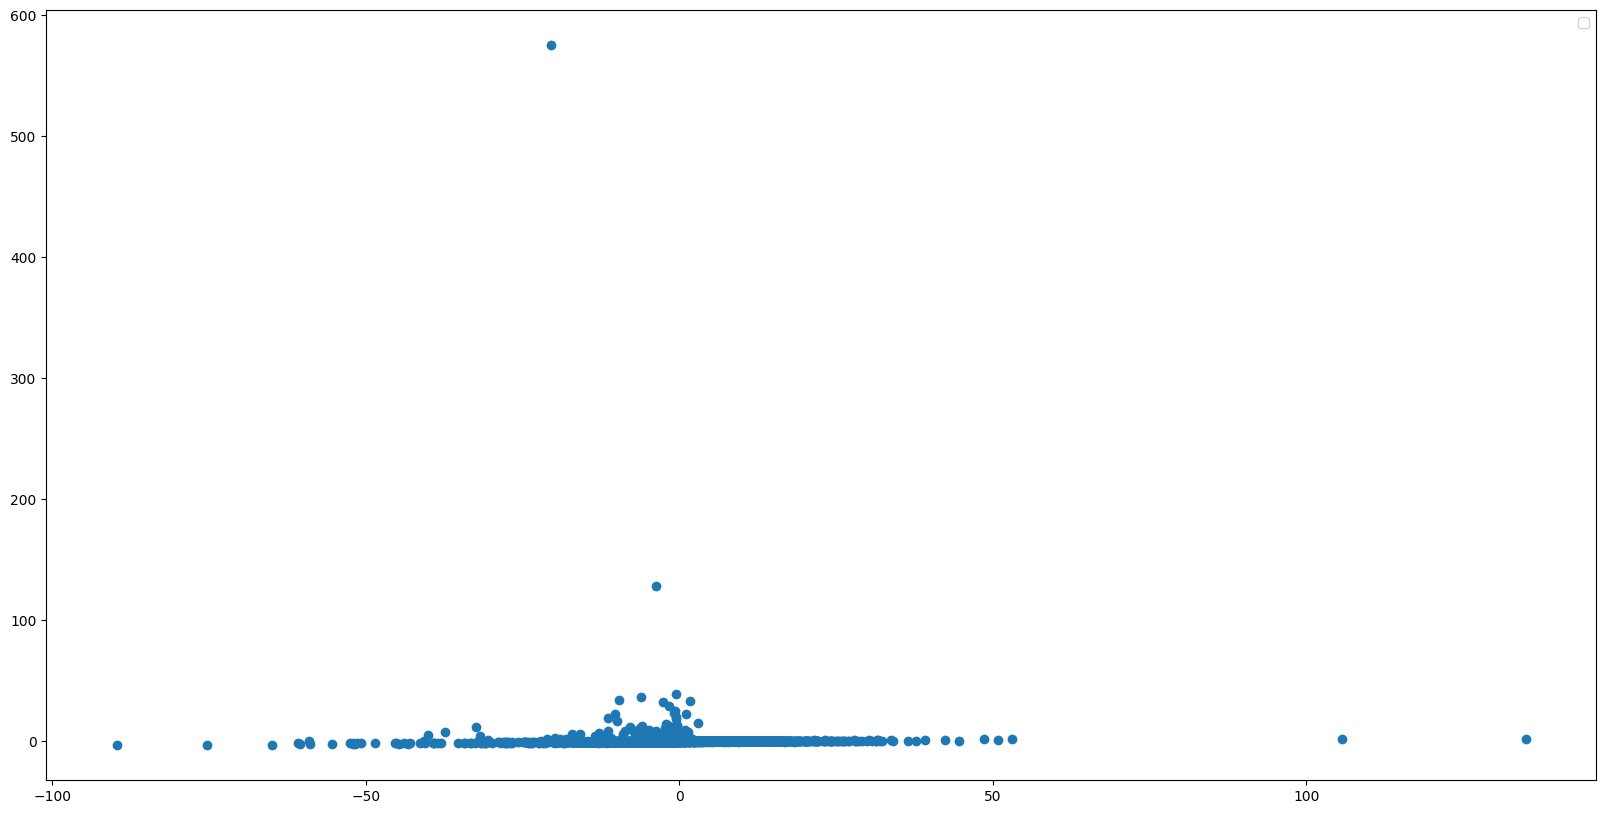

In [22]:
# plotting the results:
plt.figure(figsize=(20, 10))
plt.scatter(df_pca.PCA_2, df_pca.PCA_3)
plt.legend()
plt.show()

In [23]:
# # Plot explained variance
# fig, ax = pca.plot()

# # Scatter first 2 PCs
# fig, ax = pca.scatter()

# Make biplot with the number of features
# fig, ax = model_pca.biplot(n_feat=3)

# Principal components correlation coefficients
loadings = model_pca.components_

# Number of features before PCA
n_features = model_pca.n_features_

# Feature names before PCA
# feature_names = df.feature_names
feature_names = df.columns

# PC names
pc_list = [f"PC{i}" for i in list(range(1, n_features + 1))]

# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))

# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df["feature_names"] = feature_names
loadings_df = loadings_df.set_index("feature_names")
loadings_df

PC1           PC2           PC3           PC4
feature_names                                                                
user.followers_count   5.608459e-03  2.845300e-04  8.660331e-04 -1.459555e-03
user.friends_count     3.577089e-03 -7.624668e-05  5.576405e-04 -3.678913e-04
user.listed_count     -3.766273e-04  3.872727e-04 -1.040750e-05  6.270072e-04
user.favourites_count  4.568784e-03  1.543658e-04  2.499099e-04 -2.219208e-04
quote_count            9.998565e-26 -8.151320e-22 -2.480730e-21 -1.398927e-19
...                             ...           ...           ...           ...
úteis                  2.553161e-04  1.695714e-04  3.610202e-06 -1.593115e-04
Android                2.547771e-03  1.300498e-04  5.141288e-04 -2.064620e-03
iOS                   -3.080120e-03  4.774346e-04 -7.242921e-04  6.449387e-04
Web                    6.468296e-04 -1.146537e-03  2.351247e-04  2.223867e-03
Others                -1.144807e-04  5.390523e-04 -2.496148e-05 -8.041858e-04

[5013 rows x 4 columns]

In [91]:
loadings_df.sort_values(by="PC1", ascending=False).head(25)

feature_names       PC1       PC2       PC3       PC4
670      bolsonaro  0.664412  0.519844  0.007682 -0.273417
2935          lula  0.561073 -0.740656 -0.026988  0.064875
3814    presidente  0.175584  0.102319  0.002932 -0.063673
710         brasil  0.130108  0.033269  0.004486  0.107177
4765           vai  0.117304  0.062572  0.001436  0.155206
4597          time  0.084332 -0.121559 -0.005571  0.008507
3244          musk  0.081972  0.140157  0.003603  0.452580
658      bolsomusk  0.081499  0.151386  0.004291  0.601068
4424         sobre  0.071496  0.008652 -0.001698  0.023263
4464           stf  0.069262  0.067006  0.000109 -0.016677
1670          elon  0.067188  0.111574  0.002857  0.362158
2695          jair  0.065468  0.060442  0.000502 -0.008339
2305          hoje  0.061949  0.007361  0.004475  0.092935
1496           dia  0.059094 -0.002453  0.002839  0.056333
4396      silveira  0.057172  0.065343  0.000603 -0.087455
3772           pra  0.056414 -0.002349  0.002899  0.023186
2573       indulto  0.054384  0.062077  0.000991 -0.082523
1567           diz  0.054339  0.010473 -0.001212 -0.026826
813           capa  0.051906 -0.074605 -0.004577  0.004815
1167        contra  0.048956  0.009043 -0.000780 -0.006697
1320        daniel  0.048473  0.048346  0.000549 -0.068464
3767          povo  0.044933 -0.017743  0.003717 -0.006627
4562           ter  0.043532 -0.015940 -0.002558  0.008481
3695          pode  0.043499  0.000477 -0.001372  0.016682
3191        moraes  0.042428  0.024170 -0.001272 -0.008643

In [25]:
loadings_df.sort_values(by="PC2", ascending=False).head(25)

PC1       PC2       PC3       PC4
feature_names                                        
bolsonaro      0.664412  0.519844  0.007682 -0.273417
bolsomusk      0.081499  0.151386  0.004291  0.601068
musk           0.081972  0.140157  0.003603  0.452580
elon           0.067188  0.111574  0.002857  0.362158
presidente     0.175584  0.102319  0.002932 -0.063673
stf            0.069262  0.067006  0.000109 -0.016677
silveira       0.057172  0.065343  0.000603 -0.087455
vai            0.117304  0.062572  0.001436  0.155206
indulto        0.054384  0.062077  0.000991 -0.082523
jair           0.065468  0.060442  0.000502 -0.008339
daniel         0.048473  0.048346  0.000549 -0.068464
jairbolsonaro  0.036467  0.048112  0.000384 -0.003492
porto          0.033820  0.042098  0.000757 -0.036250
perdão         0.023419  0.035734  0.000545 -0.041415
amazônia       0.022203  0.035045  0.001108  0.110619
brasil         0.130108  0.033269  0.004486  0.107177
encontro       0.020792  0.031705  0.000769  0.106610
forças         0.033739  0.031181 -0.000021 -0.029082
seguro         0.022579  0.030258  0.000490 -0.031160
gandra         0.022917  0.030252  0.000828 -0.037263
ives           0.022811  0.029970  0.000830 -0.036810
armadas        0.030825  0.028770 -0.000048 -0.027997
decreto        0.028479  0.027041 -0.000077 -0.034506
ministro       0.037147  0.025613 -0.000786  0.000930
liberdade      0.022187  0.024899  0.000141  0.009711

In [48]:
loadings_df = loadings_df.reset_index()

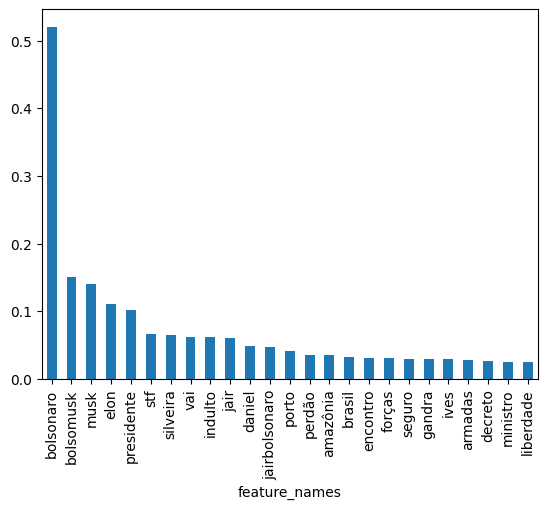

In [27]:
loadings_df.sort_values(by="PC2", ascending=False)["PC2"].head(25).plot.bar()
plt.show()

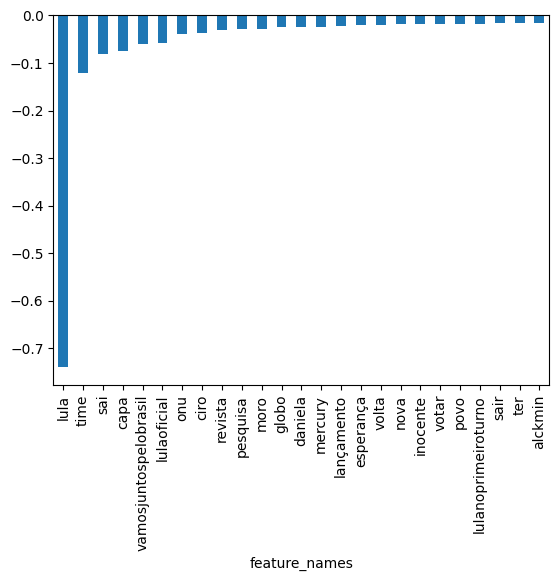

In [36]:
loadings_df.sort_values(by="PC2", ascending=True)["PC2"].head(25).plot.bar()
plt.show()

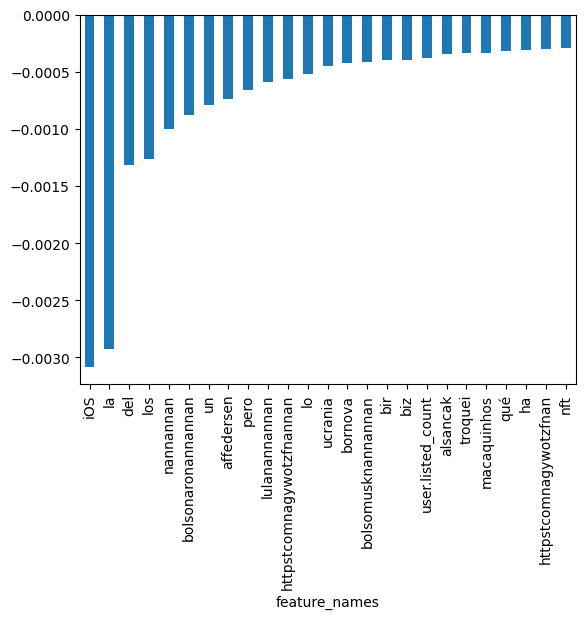

In [37]:
loadings_df.sort_values(by="PC1", ascending=True)["PC1"].head(25).plot.bar()
plt.show()

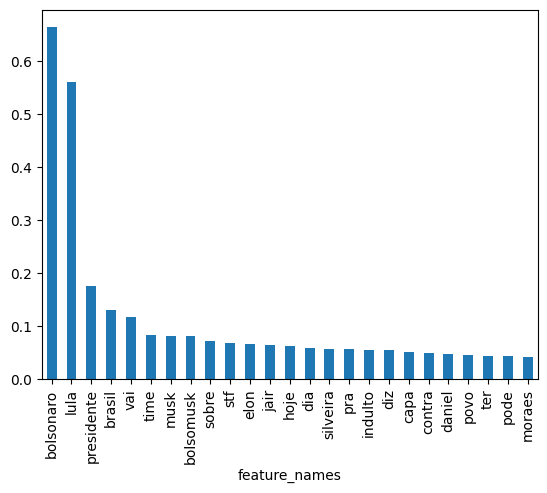

In [38]:
loadings_df.sort_values(by="PC1", ascending=False)["PC1"].head(25).plot.bar()
plt.show()

In [40]:
# !pip install bioinfokit
# from bioinfokit.visuz import cluster

In [65]:
# cluster.pcaplot(
#     x=loadings_df.sort_values(by="PC1", ascending=False)["PC1"].head(25).to_list(),
#     y=loadings_df.sort_values(by="PC1", ascending=False)["PC2"].head(25).to_list(),
#     labels=loadings_df.sort_values(by="PC1", ascending=False)["feature_names"].head(25),
#     var1=round(model_pca.explained_variance_ratio_[0] * 100, 2),
#     var2=round(model_pca.explained_variance_ratio_[1] * 100, 2),
# )
# # plt.show()

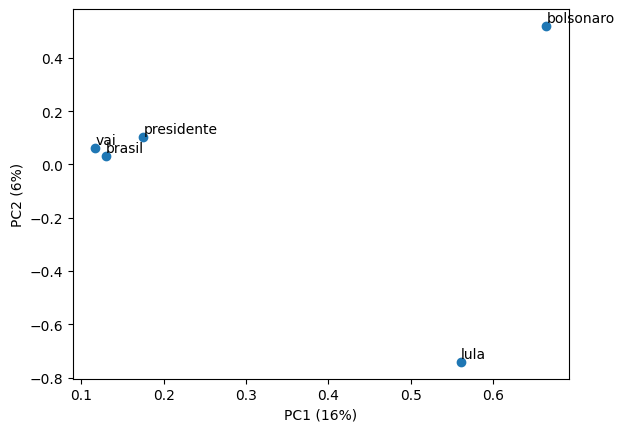

In [90]:
x = loadings_df.sort_values(by="PC1", ascending=False)["PC1"].head(5).to_list()
y = loadings_df.sort_values(by="PC1", ascending=False)["PC2"].head(5).to_list()
n = loadings_df.sort_values(by="PC1", ascending=False)["feature_names"].head(5).to_list()

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]+0.015))

plt.xlabel('PC1 (16%)')
plt.ylabel('PC2 (6%)')
plt.show()

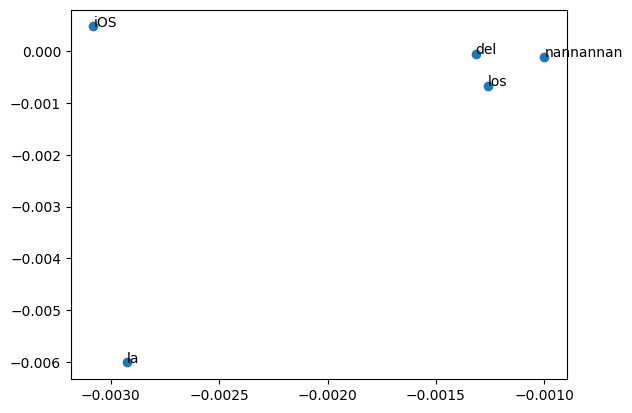

In [78]:
x = loadings_df.sort_values(by="PC1", ascending=True)["PC1"].head(5).to_list()
y = loadings_df.sort_values(by="PC1", ascending=True)["PC2"].head(5).to_list()
n = loadings_df.sort_values(by="PC1", ascending=True)["feature_names"].head(5).to_list()

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

plt.show()

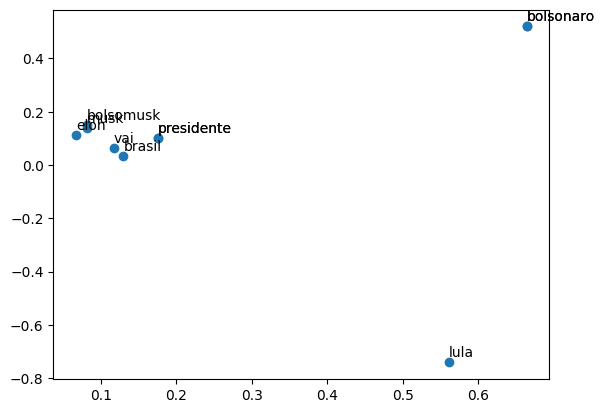

In [85]:
x = loadings_df.sort_values(by="PC1", ascending=False)["PC1"].head(5).to_list() + loadings_df.sort_values(by="PC2", ascending=False)["PC1"].head(5).to_list()
y = loadings_df.sort_values(by="PC1", ascending=False)["PC2"].head(5).to_list() + loadings_df.sort_values(by="PC2", ascending=False)["PC2"].head(5).to_list()
n = loadings_df.sort_values(by="PC1", ascending=False)["feature_names"].head(5).to_list()  + loadings_df.sort_values(by="PC2", ascending=False)["feature_names"].head(5).to_list()

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i]+0.00, y[i]+0.02))

plt.show()

In [77]:
print(x)

[-0.0030801199562547933, -0.0029262475609627605, -0.0013171167619509122, -0.0012614174766597257, -0.0009998271882627047, 0.664411861523421, 0.5610727456457572, 0.17558442785582787, 0.1301075750381384, 0.1173038777796815]


In [92]:
loadings_df.to_csv(
    f"{file_path + file_folder_postproc}/06.pca.loadings.csv", index=False
)

In [34]:
df_pca["user_id"] = users
df_pca.shape

(78856, 5)

In [35]:
df_pca.to_csv(
    f"{file_path + file_folder_postproc}/{file_name_postproc}.csv", index=False
)